Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

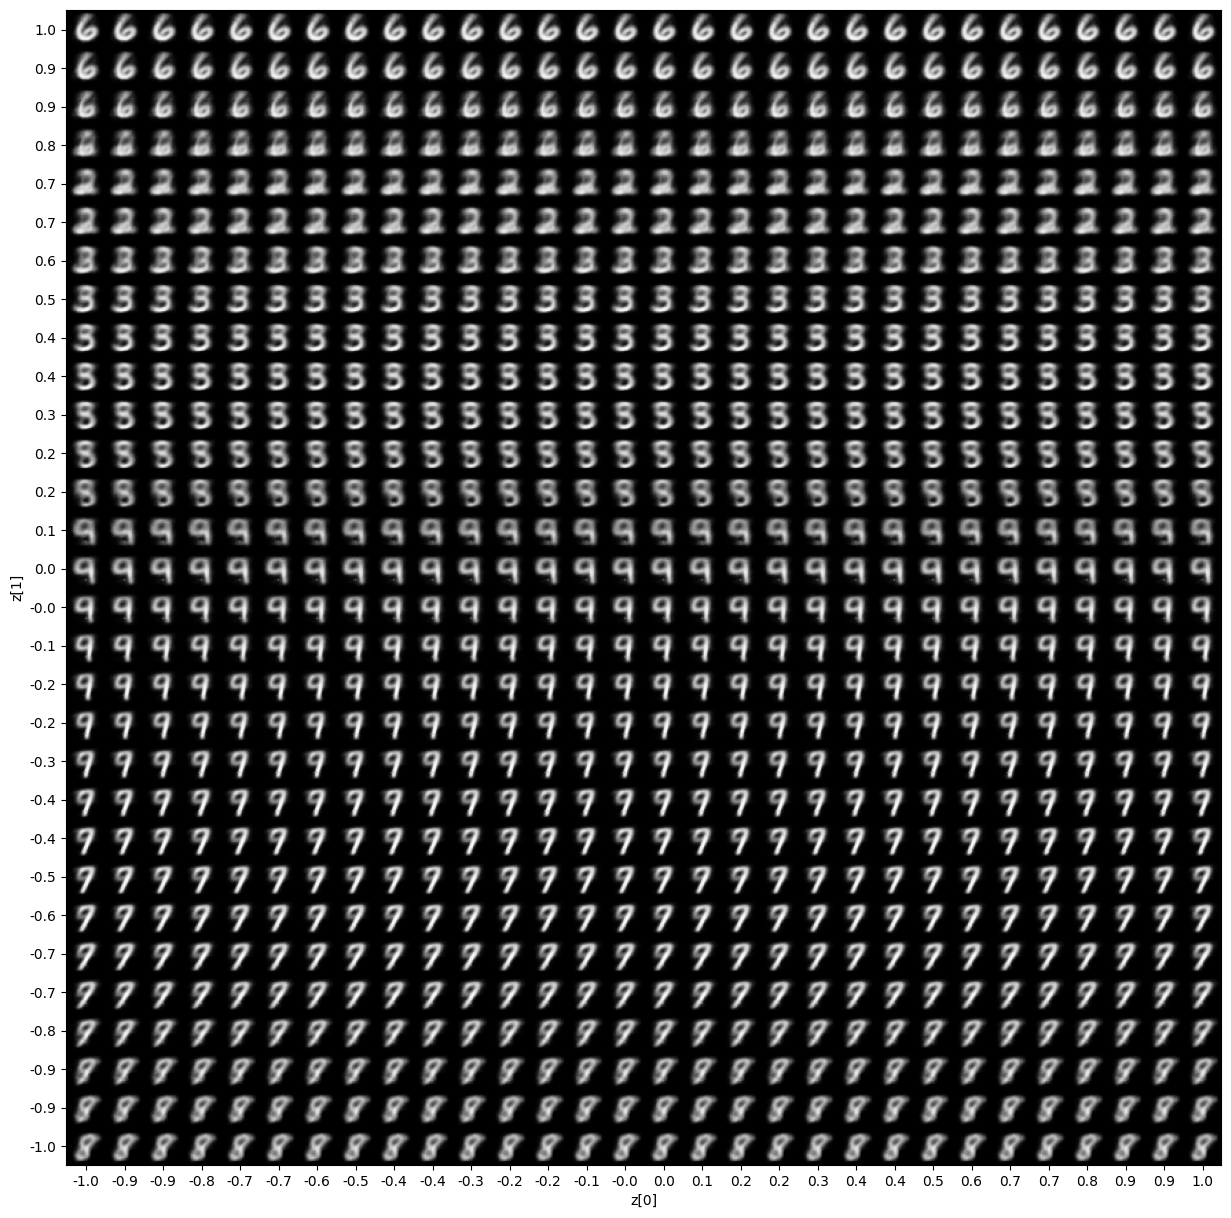

1875/1875 [==============================] - 4s 2ms/step


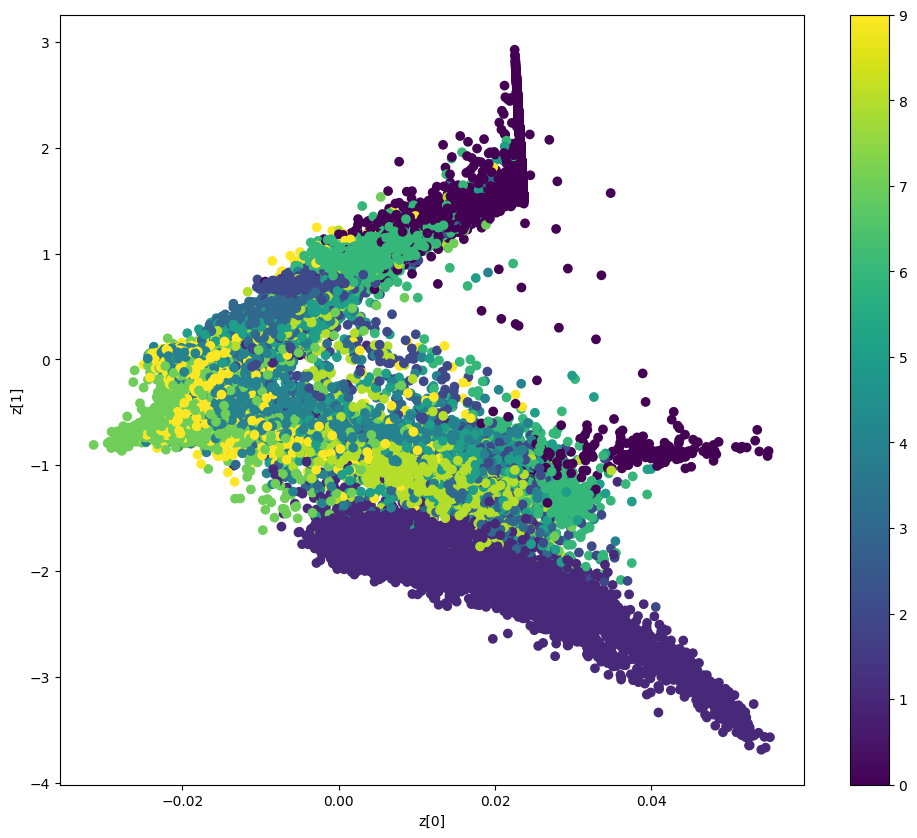

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

"""
## Define the VAE as a `Model` with a custom `train_step`
"""


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    #keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


"""
## Train the VAE
"""

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

"""
## Display a grid of sampled digits
"""

import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

"""
## Display how the latent space clusters different digit classes
"""


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

2025-04-20 23:34:45.489173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 23:34:45.498994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745163285.511460  177705 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745163285.514576  177705 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 23:34:45.527043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Displaying train data and noisy train data...


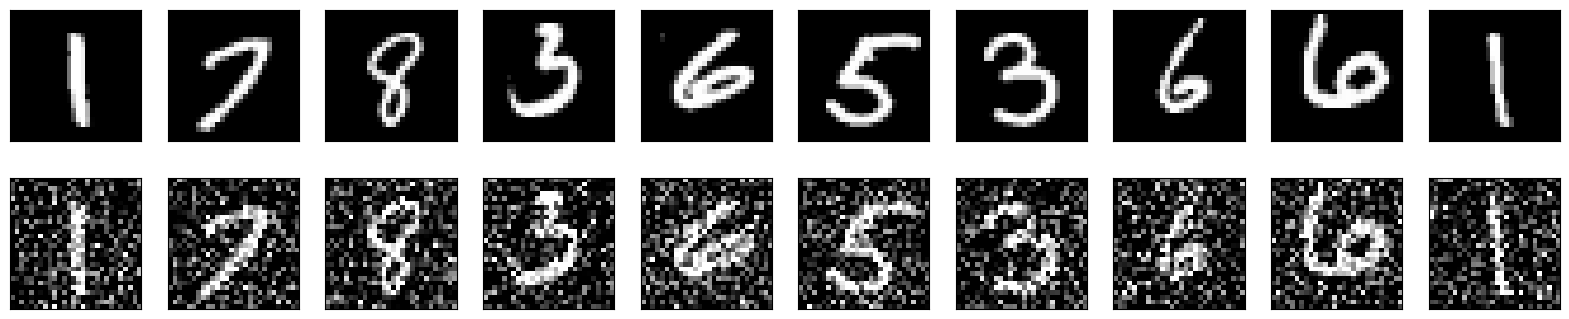


Training VAE with latent dimension 8...


I0000 00:00:1745163288.691049  177705 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "encoder_z8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,605,888 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      2,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      2,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 8)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,684,496 (6.43 MB)

 Trainable params: 1,684,496 (6.43 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_z8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │        28,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,905 (327.75 KB)

 Trainable params: 83,905 (327.75 KB)

 Non-trainable params: 0 (0.00 B)

Training VAE z_dim=8 on clean data...
Epoch 1/30


I0000 00:00:1745163290.871316  177815 service.cc:148] XLA service 0x43092830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745163290.871348  177815 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-04-20 23:34:50.905382: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745163291.090007  177815 cuda_dnn.cc:529] Loaded cuDNN version 90300


 32/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 2.0004 - loss: 480.2865 - reconstruction_loss: 478.2862

I0000 00:00:1745163293.790511  177815 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - kl_loss: 5.9824 - loss: 249.1816 - reconstruction_loss: 243.1992
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 15.2712 - loss: 122.3469 - reconstruction_loss: 107.0757
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 16.0839 - loss: 114.8215 - reconstruction_loss: 98.7377
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 16.3923 - loss: 111.9372 - reconstruction_loss: 95.5448
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 16.5588 - loss: 110.2548 - reconstruction_loss: 93.6960
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 16.6594 - loss: 108.5022 - reconstruction_loss: 91.8428
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 16.7919 - loss: 107.6568 - reconstruction_loss: 90.8648
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 16.8170 - loss: 106.8596 - reconstruction_loss: 90.0426
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_l

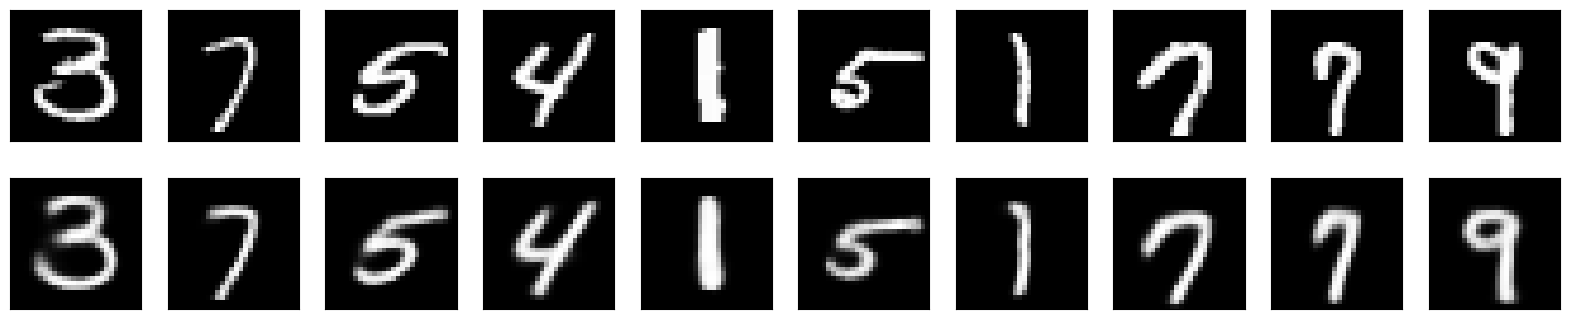

Visualizing latent space for z_dim=8...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


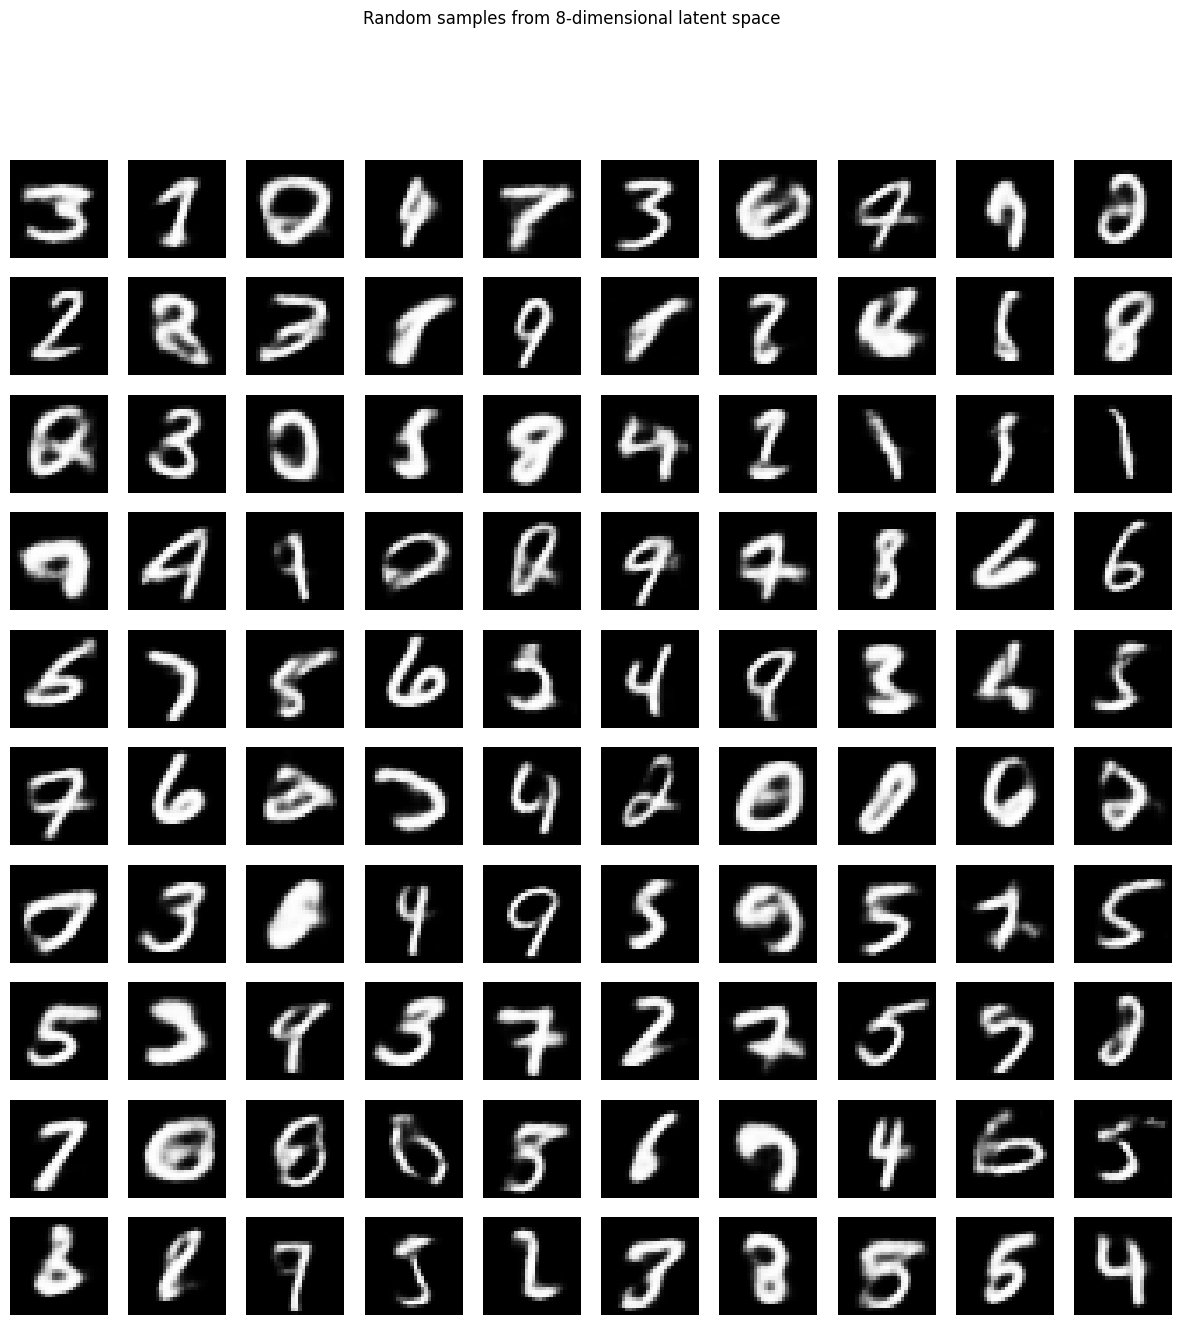

Plotting label clusters for z_dim=8...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


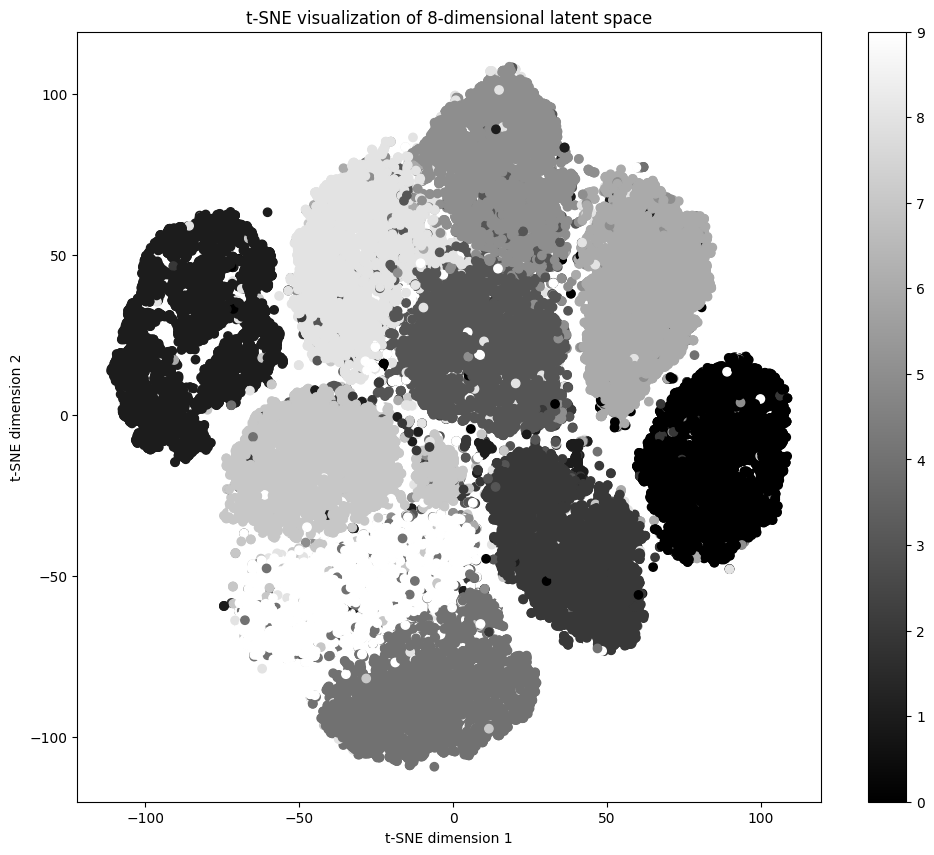

Training VAE z_dim=8 for denoising (noisy data)...
Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - kl_loss: 15.2978 - loss: 135.6602 - reconstruction_loss: 120.3625
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 16.1428 - loss: 112.2683 - reconstruction_loss: 96.1255
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 16.3085 - loss: 110.8711 - reconstruction_loss: 94.5626
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 16.3687 - loss: 109.6485 - reconstruction_loss: 93.2798
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 16.4587 - loss: 109.0843 - reconstruction_loss: 92.6257
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 16.4649 - loss: 108.8307 - reconstruction_loss: 92.3658
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 16.5361 - loss: 108.2328 - reconstruction_loss: 91.6968
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 16.5393 - loss: 107.9976 - reconstruction_lo

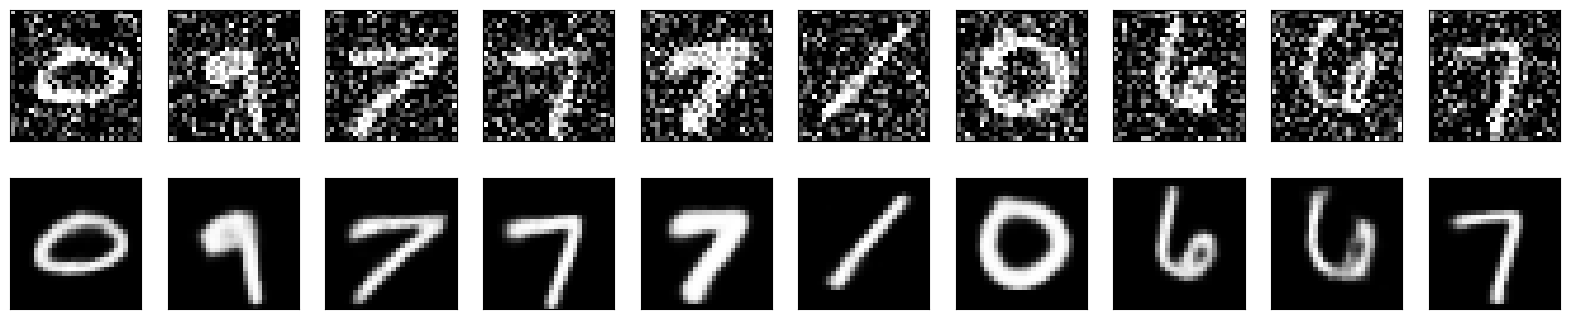

Saving generated images for z_dim=8...

Training VAE with latent dimension 16...


Model: "encoder_z16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 6272)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  1,605,888 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      4,112 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      4,112 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 16)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,688,608 (6.44 MB)

 Trainable params: 1,688,608 (6.44 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_z16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

Training VAE z_dim=16 on clean data...
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - kl_loss: 10.2166 - loss: 224.8158 - reconstruction_loss: 214.5992
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 21.0731 - loss: 116.6219 - reconstruction_loss: 95.5487
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 22.5054 - loss: 107.7543 - reconstruction_loss: 85.2489
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 22.9612 - loss: 105.2052 - reconstruction_loss: 82.2440
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 23.3143 - loss: 103.4681 - reconstruction_loss: 80.1539
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 23.6098 - loss: 102.4294 - reconstruction_loss: 78.8197
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 23.7322 - loss: 101.5516 - reconstruction_loss: 77.8194
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 23.7504 - loss: 100.6573 - reconstruction_loss: 76.9070
Epoch 9/

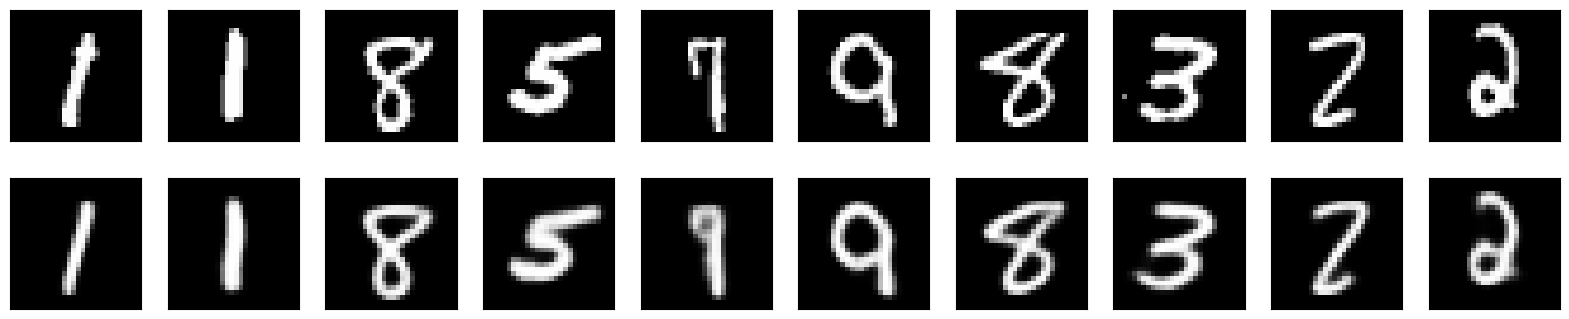

Visualizing latent space for z_dim=16...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


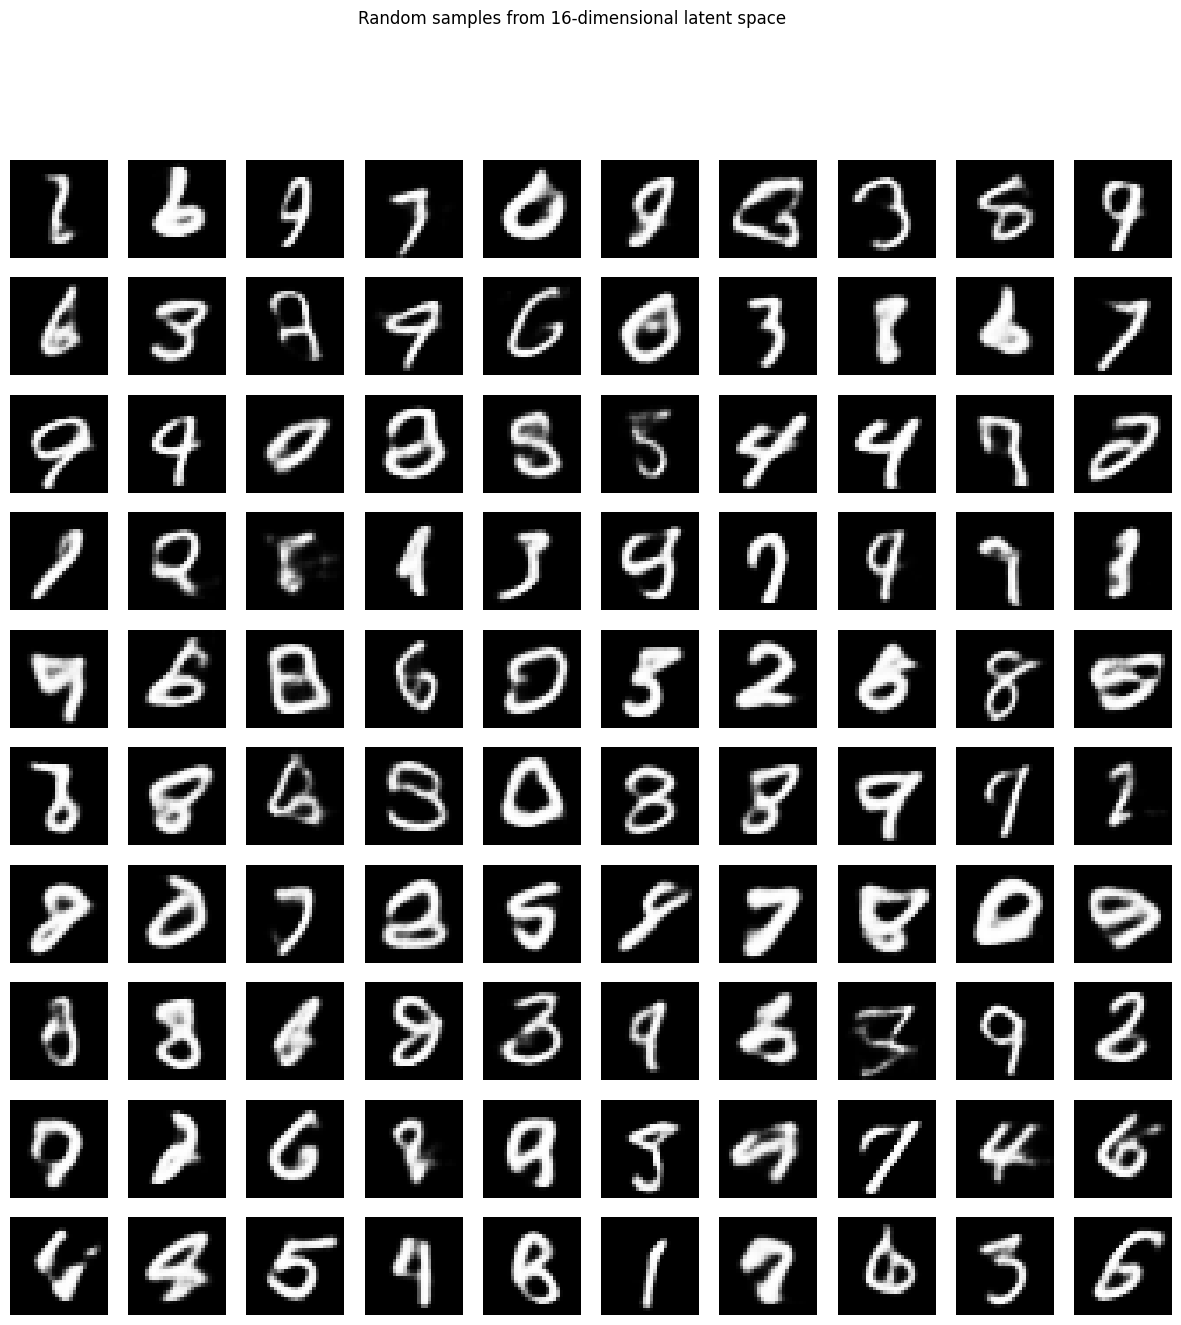

Plotting label clusters for z_dim=16...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


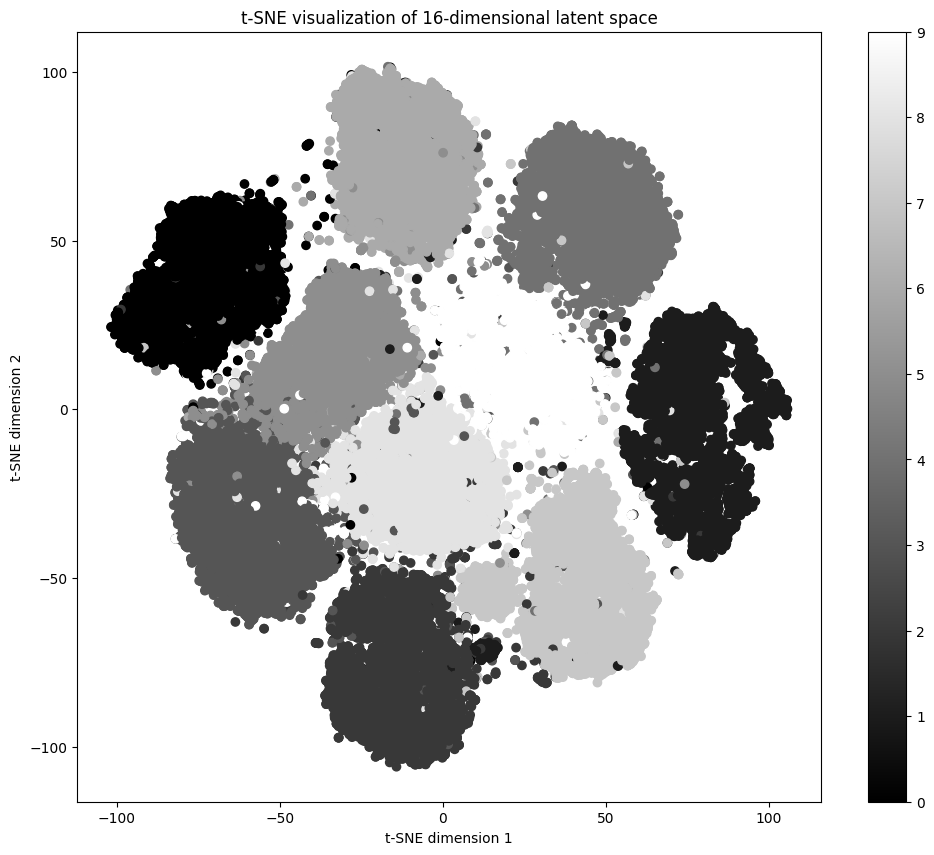

Training VAE z_dim=16 for denoising (noisy data)...
Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 21.7952 - loss: 122.3040 - reconstruction_loss: 100.5088
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 21.9515 - loss: 105.8882 - reconstruction_loss: 83.9366
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 21.9941 - loss: 104.9787 - reconstruction_loss: 82.9847
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 21.9315 - loss: 104.1500 - reconstruction_loss: 82.2186
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 22.0012 - loss: 103.9135 - reconstruction_loss: 81.9123
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 21.9999 - loss: 103.5872 - reconstruction_loss: 81.5873
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 22.0506 - loss: 103.3682 - reconstruction_loss: 81.3176
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 22.0223 - loss: 103.0445 - reconstruction_l

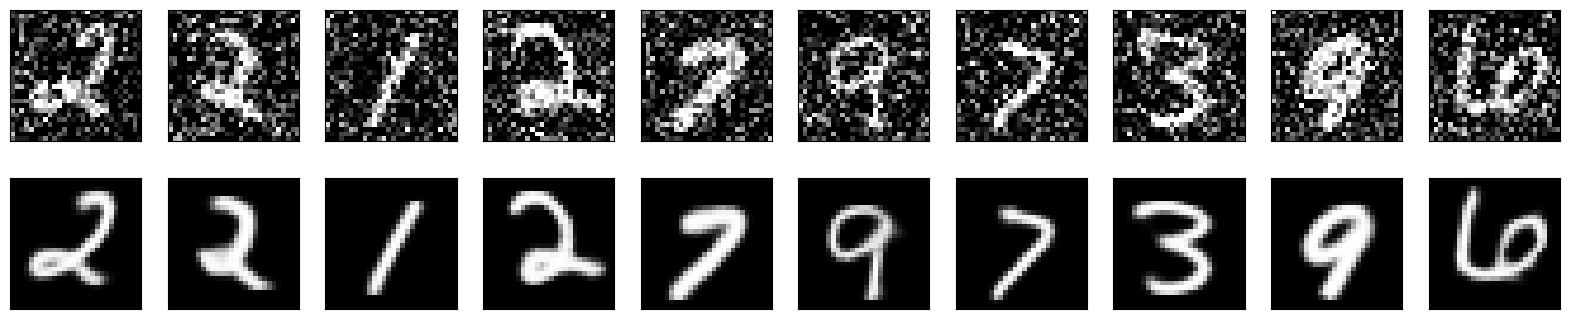

Saving generated images for z_dim=16...

Training VAE with latent dimension 32...


Model: "encoder_z32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 6272)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  1,605,888 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │      8,224 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │      8,224 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 32)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,696,832 (6.47 MB)

 Trainable params: 1,696,832 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_z32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3136)           │       103,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,169 (621.75 KB)

 Trainable params: 159,169 (621.75 KB)

 Non-trainable params: 0 (0.00 B)

Training VAE z_dim=32 on clean data...
Epoch 1/30
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 10.1482 - loss: 230.2262 - reconstruction_loss: 220.0780

2025-04-20 23:48:03.510129: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads



469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - kl_loss: 10.2245 - loss: 229.2728 - reconstruction_loss: 219.0483
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 22.3896 - loss: 119.4750 - reconstruction_loss: 97.0854
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 23.2520 - loss: 109.5848 - reconstruction_loss: 86.3328
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 23.8125 - loss: 106.0626 - reconstruction_loss: 82.2501
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 24.1148 - loss: 104.1917 - reconstruction_loss: 80.0769
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 24.4149 - loss: 103.1150 - reconstruction_loss: 78.7001
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 24.5284 - loss: 102.1614 - reconstruction_loss: 77.6329
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 24.6146 - loss: 101.3243 - reconstruction_loss: 76.7097
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_

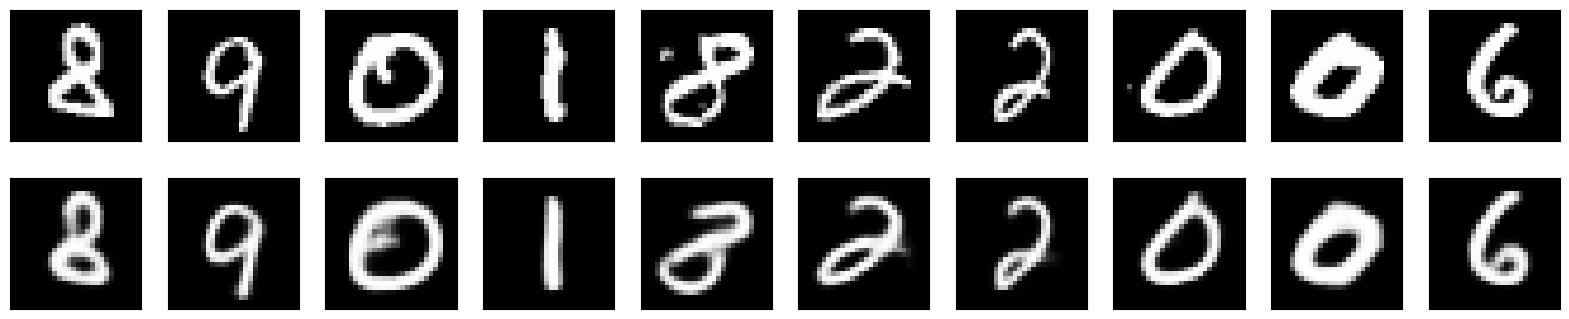

Visualizing latent space for z_dim=32...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


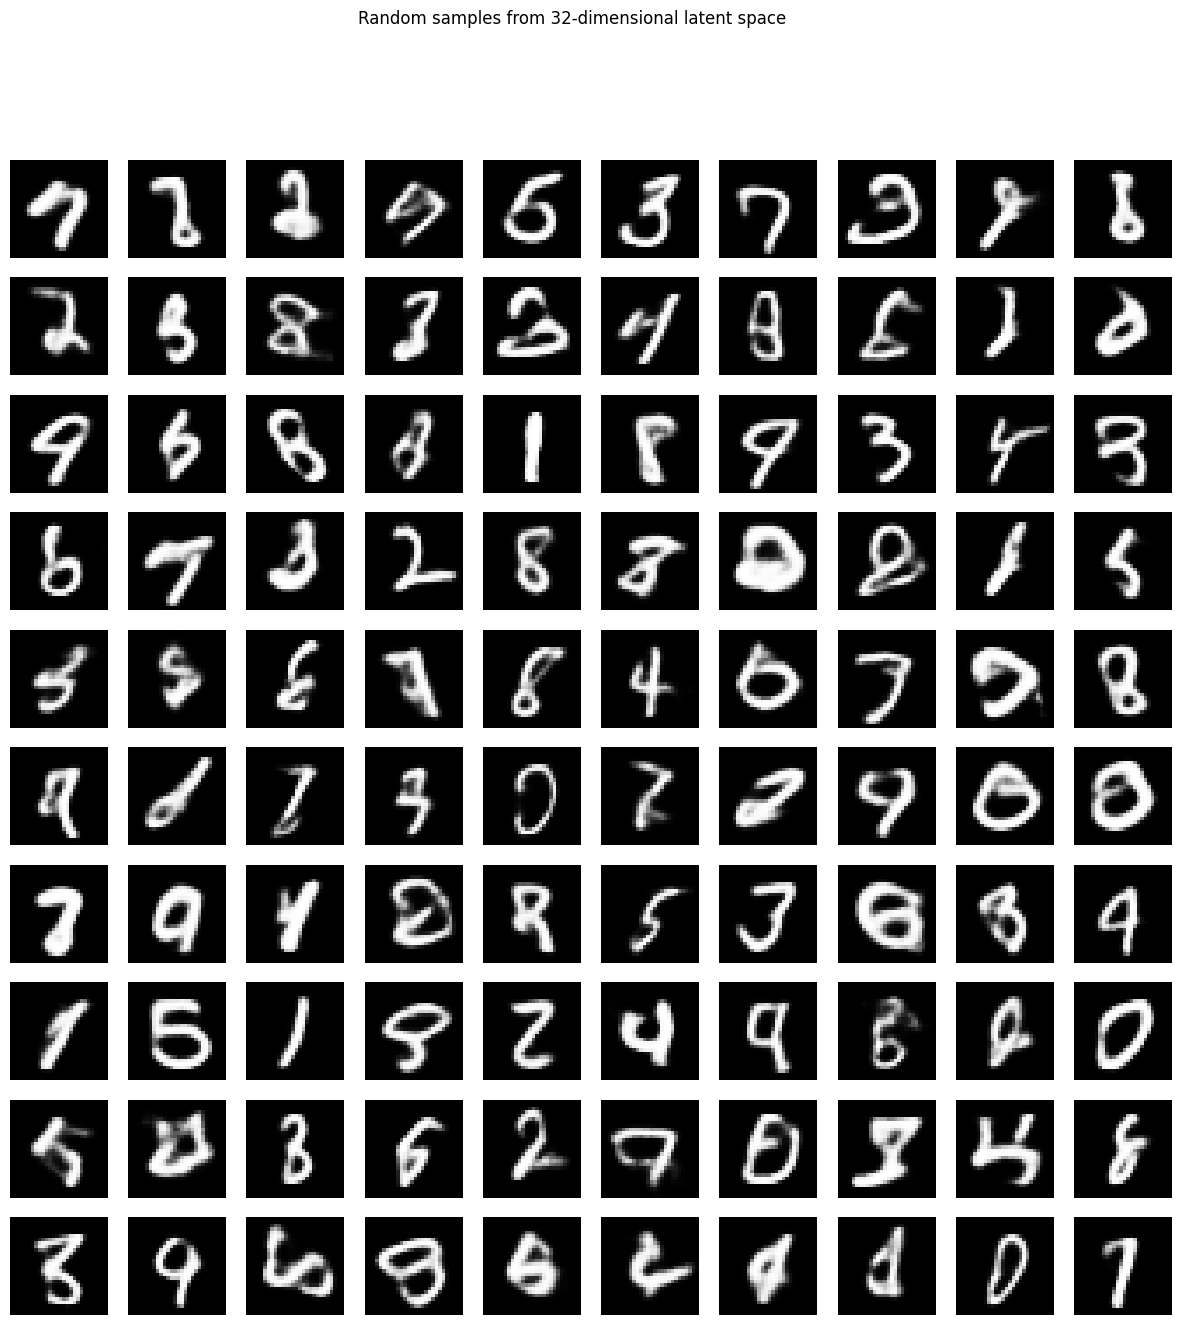

Plotting label clusters for z_dim=32...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


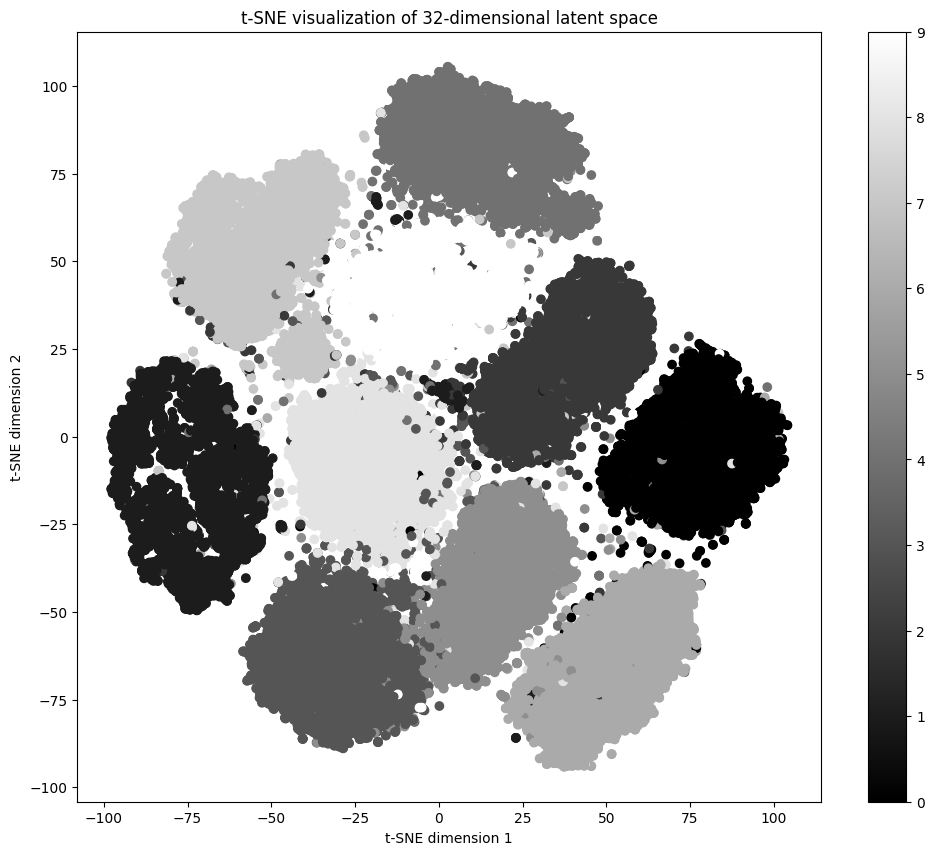

Training VAE z_dim=32 for denoising (noisy data)...
Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - kl_loss: 22.8207 - loss: 122.7399 - reconstruction_loss: 99.9192
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 22.5839 - loss: 106.7137 - reconstruction_loss: 84.1299
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 22.5563 - loss: 105.5618 - reconstruction_loss: 83.0055
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 22.5054 - loss: 104.8492 - reconstruction_loss: 82.3438
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 22.5028 - loss: 104.6595 - reconstruction_loss: 82.1567
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 22.5458 - loss: 104.2258 - reconstruction_loss: 81.6801
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 22.5412 - loss: 104.0914 - reconstruction_loss: 81.5501
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 22.5322 - loss: 103.7224 - reconstruction_lo

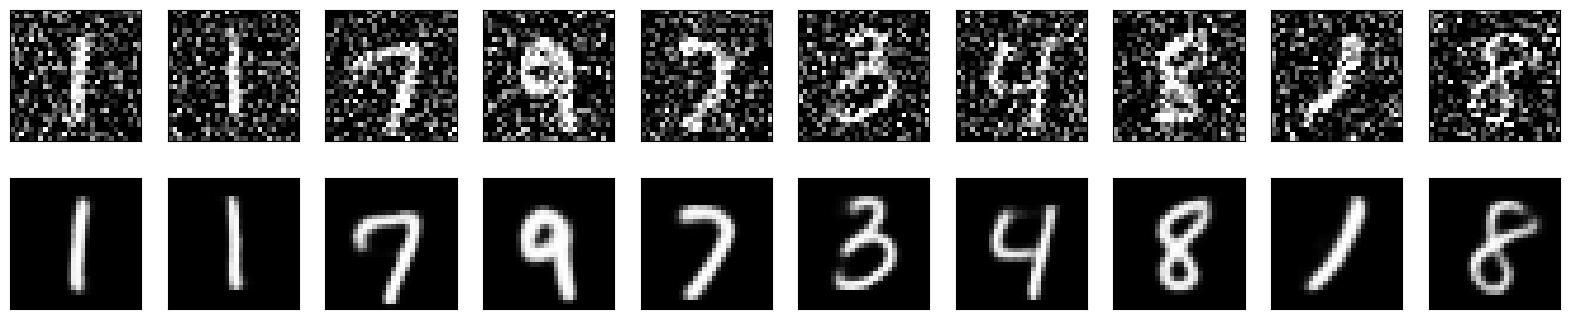

Saving generated images for z_dim=32...
VAE training complete for all latent dimensions!


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from PIL import Image

def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def save_generated_images(images, z_dim, prefix="vae_generated_images", limit=100):
    save_dir = os.path.join(prefix, f"z{z_dim}")
    os.makedirs(save_dir, exist_ok=True)

    for i in range(min(len(images), limit)):
        img = images[i]
        img = np.squeeze(img)  
        img = (img * 255).astype(np.uint8)  # [0,1] → [0,255]
        img = Image.fromarray(img).convert("RGB")  

        img = img.resize((299, 299))   # Resize to InceptionV3 input size
        img.save(os.path.join(save_dir, f"{i+1:05d}.png"))

def plot_latent_space(decoder, z_dim, n=30, figsize=15):
    """Display a grid of sampled digits from the latent space"""
    digit_size = 28
    
    # For 2D latent space, we create a grid visualization
    if z_dim == 2:
        figure = np.zeros((digit_size * n, digit_size * n))
        scale = 1.0
        grid_x = np.linspace(-scale, scale, n)
        grid_y = np.linspace(-scale, scale, n)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap="Greys_r")
        plt.title(f"Latent Space Visualization for z_dim={z_dim}")
        plt.savefig(f"vae_latent_space_z{z_dim}.png")
        plt.show()
    else:
        # For higher dimensions, show random samples
        n_samples = min(n*n, 100)
        grid_size = int(np.sqrt(n_samples))
        
        # Generate random samples from normal distribution
        z_samples = np.random.normal(0, 1, size=(n_samples, z_dim))
        
        # Decode the samples
        x_decoded = decoder.predict(z_samples)
        
        # Plot the results
        plt.figure(figsize=(figsize, figsize))
        for i in range(n_samples):
            ax = plt.subplot(grid_size, grid_size, i+1)
            plt.imshow(x_decoded[i].reshape(28, 28), cmap='Greys_r')
            plt.axis('off')
        
        plt.suptitle(f"Random samples from {z_dim}-dimensional latent space")
        plt.savefig(f"vae_random_samples_z{z_dim}.png")
        plt.show()

def plot_label_clusters(encoder, data, labels, z_dim):
    # display a 2D plot of the digit classes in the latent space
    if z_dim == 2:
        z_mean, _, _ = encoder.predict(data)
        plt.figure(figsize=(12, 10))
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
        plt.colorbar()
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.title("Latent Space Clusters")
        plt.savefig(f"vae_clusters_z{z_dim}.png")
        plt.show()
    else:
        # For higher dimensions, use t-SNE to reduce dimensions for visualization
        from sklearn.manifold import TSNE
        z_mean, _, _ = encoder.predict(data)
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        z_tsne = tsne.fit_transform(z_mean)
        plt.figure(figsize=(12, 10))
        plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels)
        plt.colorbar()
        plt.xlabel("t-SNE dimension 1")
        plt.ylabel("t-SNE dimension 2")
        plt.title(f"t-SNE visualization of {z_dim}-dimensional latent space")
        plt.savefig(f"vae_tsne_z{z_dim}.png")
        plt.show()

# Sampling layer - same as original VAE code
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE class - same as original VAE code
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x, y = data if isinstance(data, tuple) else (data, data)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# Prepare the data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(x_train)
test_data = preprocess(x_test)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
print("Displaying train data and noisy train data...")
display(train_data, noisy_train_data)

# Use multiple latent dimensions
z_dims = [8, 16, 32]
encoders = {}
decoders = {}
vaes = {}

for z_dim in z_dims:
    print(f"\nTraining VAE with latent dimension {z_dim}...")
    
    # Build the encoder - structure identical to original VAE
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    z_mean = layers.Dense(z_dim, name="z_mean")(x)
    z_log_var = layers.Dense(z_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name=f"encoder_z{z_dim}")
    encoder.summary()
    
    # Build the decoder - structure identical to original VAE
    latent_inputs = keras.Input(shape=(z_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name=f"decoder_z{z_dim}")
    decoder.summary()
    
    # Build the VAE - using the original VAE class
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    
    # Train the VAE on clean data - same as original (30 epochs)
    print(f"Training VAE z_dim={z_dim} on clean data...")
    vae.fit(train_data, epochs=30, batch_size=128)
    
    # Test the VAE
    print("Evaluating on test data...")
    z_mean_test, z_log_var_test, z_test = encoder.predict(test_data)
    predictions = decoder.predict(z_test)
    print(f"\nz_dim: {z_dim} test_data, predictions:")
    display(test_data, predictions)
    
    # Visualize the latent space
    print(f"Visualizing latent space for z_dim={z_dim}...")
    plot_latent_space(decoder, z_dim)
    
    # Plot the label clusters
    print(f"Plotting label clusters for z_dim={z_dim}...")
    plot_label_clusters(encoder, train_data, y_train, z_dim)
    
    # Train on noisy data for denoising
    print(f"Training VAE z_dim={z_dim} for denoising (noisy data)...")
    vae.fit(noisy_train_data, train_data, epochs=100, batch_size=128)
    
    # Test the VAE on noisy data
    z_mean_noisy, z_log_var_noisy, z_noisy = encoder.predict(noisy_test_data)
    denoised_predictions = decoder.predict(z_noisy)
    print(f"\nz_dim: {z_dim} noisy_test_data, denoised predictions:")
    display(noisy_test_data, denoised_predictions)
    
    # Save the generated images
    print(f"Saving generated images for z_dim={z_dim}...")
    save_generated_images(denoised_predictions, z_dim)
    
    # Store models for later use
    encoders[z_dim] = encoder
    decoders[z_dim] = decoder
    vaes[z_dim] = vae

print("VAE training complete for all latent dimensions!")


 z_dim = 8 then plot the latent space:


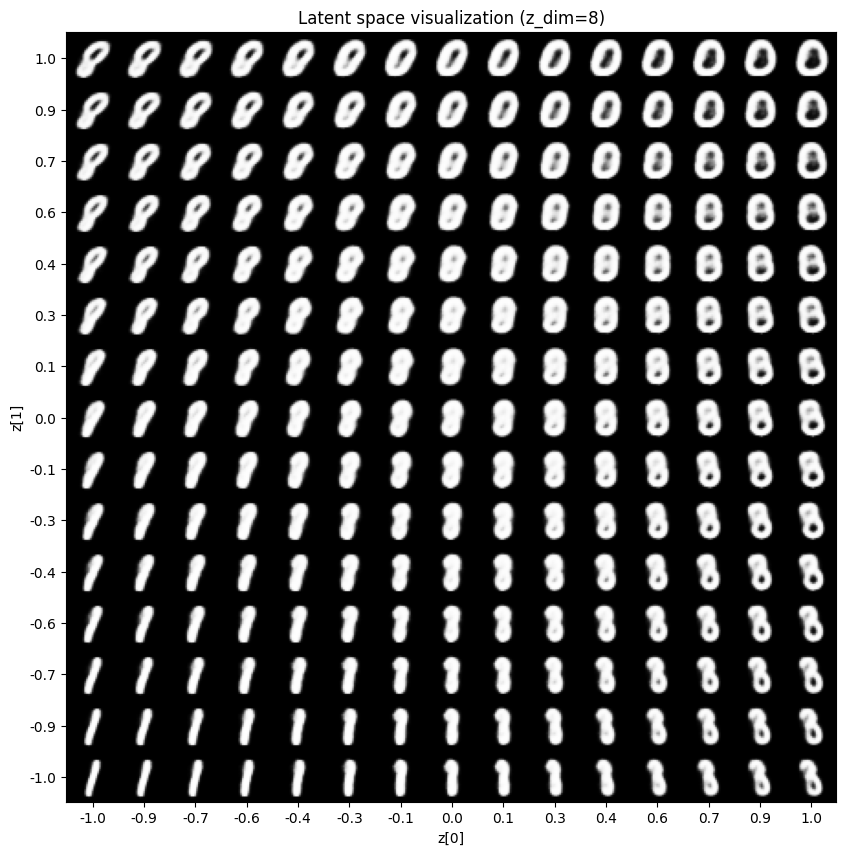

 z_dim = 8 then plot the label clusters:


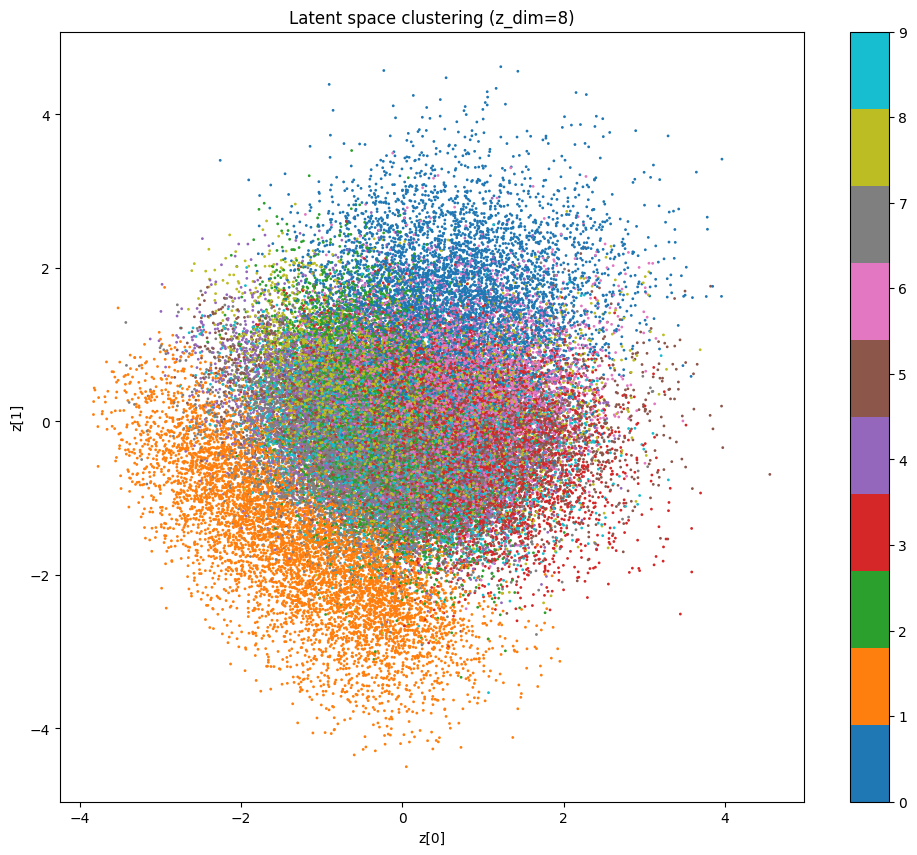


 z_dim = 16 then plot the latent space:


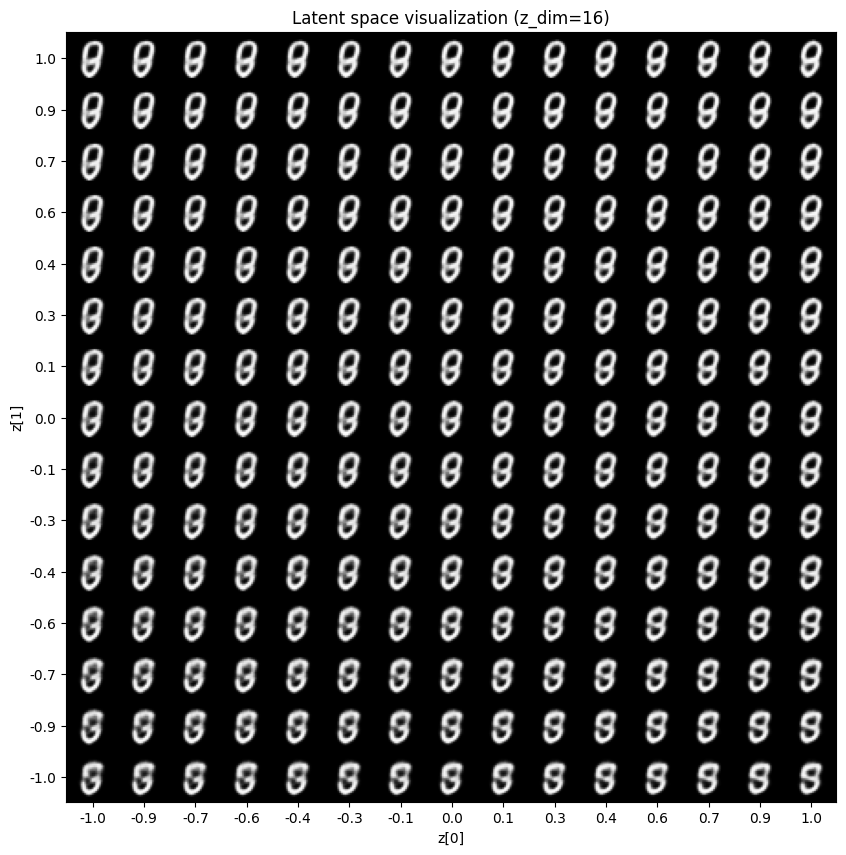

 z_dim = 16 then plot the label clusters:


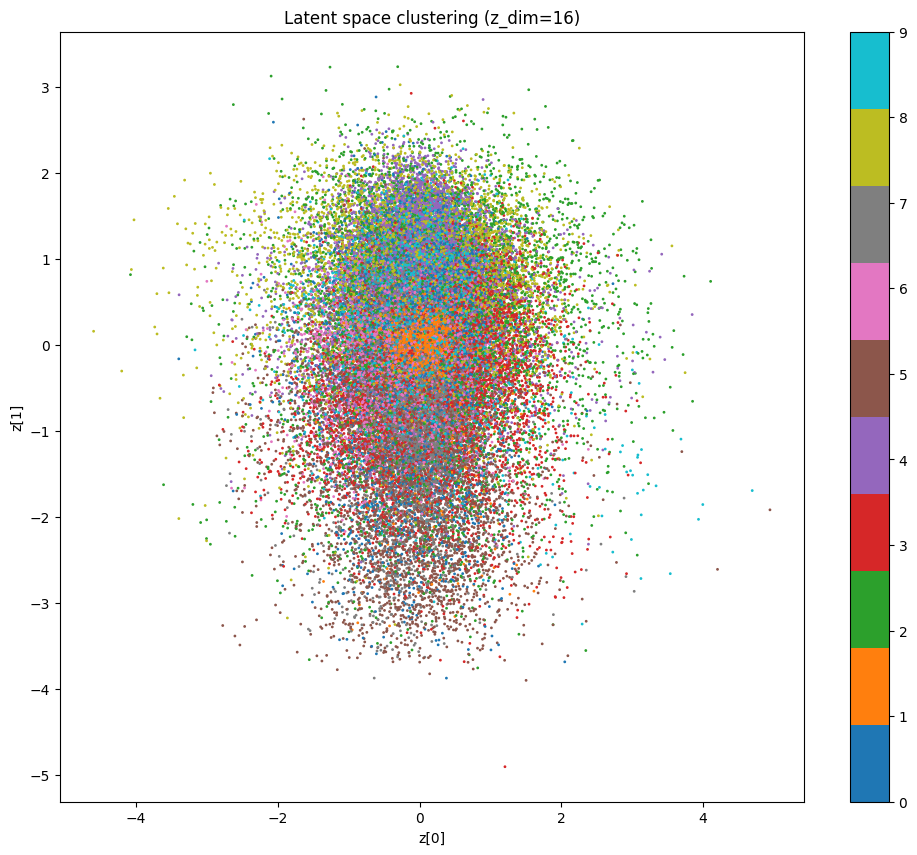


 z_dim = 32 then plot the latent space:


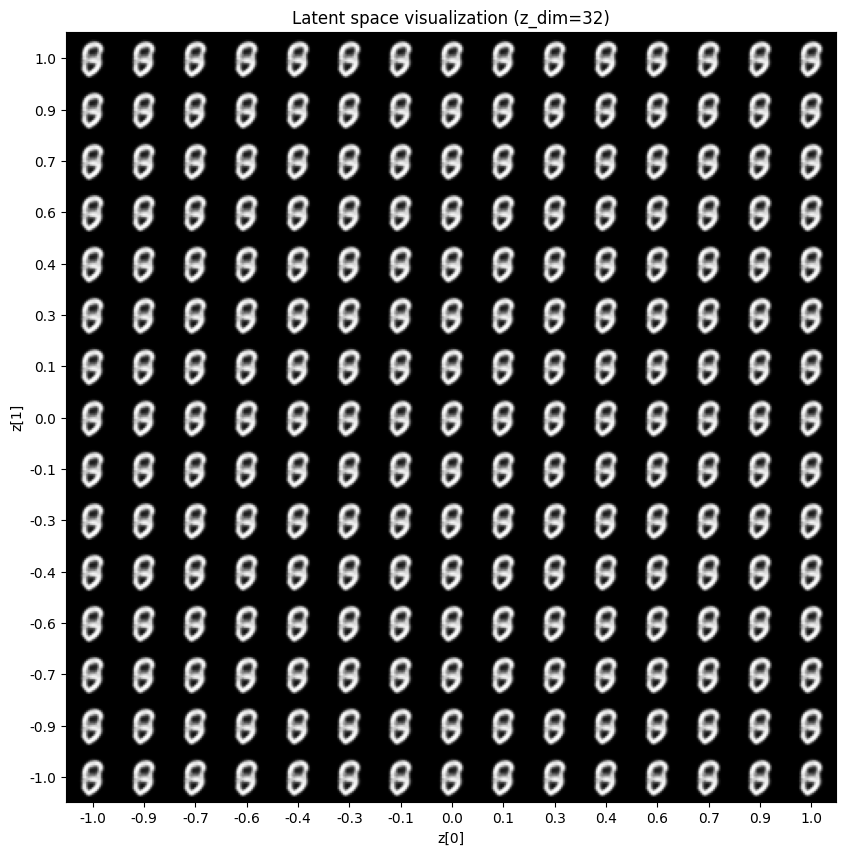

 z_dim = 32 then plot the label clusters:


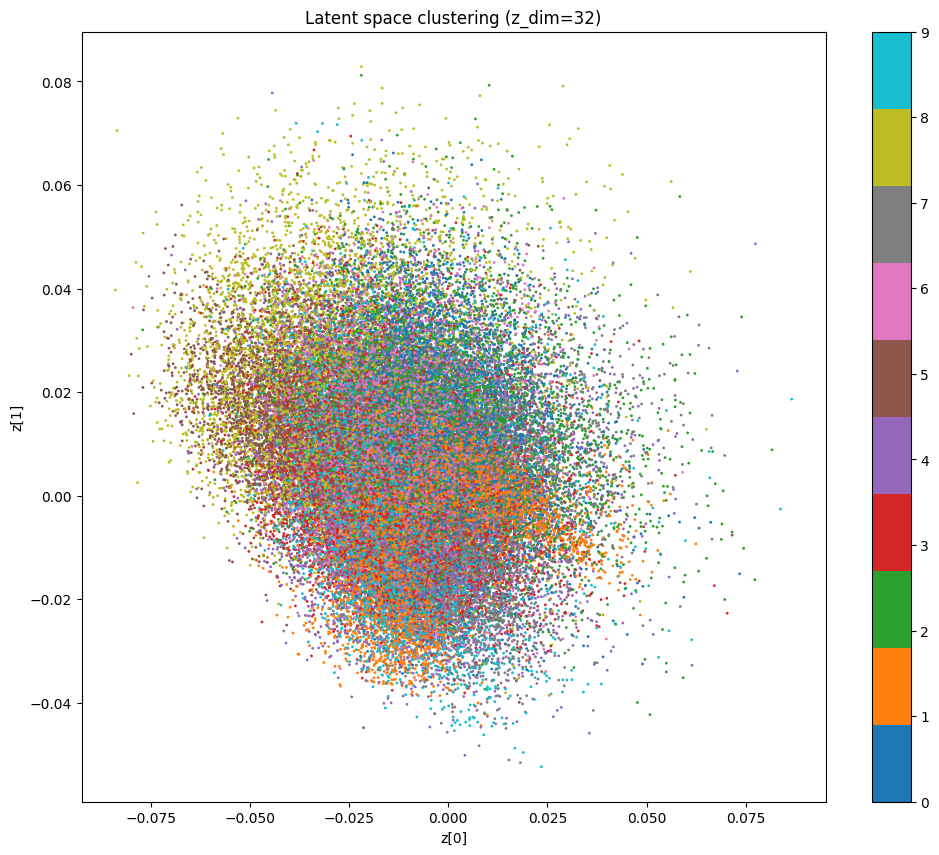

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import keras

# ------- Latent Space Visualization --------

def plot_latent_space(decoder, z_dim, n=15, figsize=10):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n), dtype=np.float32)

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            a = np.array([xi, yi])
            b = np.zeros(z_dim - 2)  # Ensure b is a NumPy array
            z_sample = np.concatenate((a, b))
            z_sample = np.expand_dims(z_sample, axis=0)
            
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f"Latent space visualization (z_dim={z_dim})")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

# ------- Cluster Visualization --------

def plot_label_clusters(encoder, data, labels, z_dim):
    z_mean, _, _ = encoder.predict(data, verbose=0)

    if z_dim > 2:
        z_mean = z_mean[:, :2]

    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap="tab10", s=1)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f"Latent space clustering (z_dim={z_dim})")
    plt.show()

# ------- Load MNIST + Normalize --------

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0

for z_dim in [8, 16, 32]:
    print(f"\n z_dim = {z_dim} then plot the latent space:")
    plot_latent_space(decoders[z_dim], z_dim)

    print(f" z_dim = {z_dim} then plot the label clusters:")
    plot_label_clusters(encoders[z_dim], x_train, y_train, z_dim)

In [6]:
import numpy as np

for z_dim in [8, 16, 32]:
    
    a = np.array([1, 1])  # Assume xi and yi are scalars
    b = [0] * (z_dim - 2)    # Pad with zeros
    z_sample = np.array([np.concatenate((a, b))])  # Shape: (1, z_dim)
    print(f"z_dim = {z_dim} then z_sample:")
    print(z_sample)

z_dim = 8 then z_sample:
[[1 1 0 0 0 0 0 0]]
z_dim = 16 then z_sample:
[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
z_dim = 32 then z_sample:
[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [7]:
from PIL import Image
import os
import numpy as np

def save_real_images_from_mnist(test_data, save_dir="vae_generated_images/real", limit=1000):
    os.makedirs(save_dir, exist_ok=True)
    for i in range(min(len(test_data), limit)):
        img = test_data[i]
        img = np.squeeze(img)  # 去掉 channel 維度 (28, 28, 1) -> (28, 28)
        img = (img * 255).astype(np.uint8)
        img = Image.fromarray(img).convert("RGB")
        img = img.resize((299, 299))  # 符合 InceptionV3 要求
        img.save(os.path.join(save_dir, f"{i+1:05d}.png"))


from tensorflow.keras.datasets import mnist

# 載入 MNIST 測試集
(_, _), (test_data, _) = mnist.load_data()
test_data = np.expand_dims(test_data, -1).astype("float32") / 255.0

# 儲存為真實圖像對照組
save_real_images_from_mnist(test_data, limit=500)  # 你可以改成 500 或更多

In [8]:
import numpy as np
import tensorflow as tf
import os
import glob
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from scipy.linalg import sqrtm

# 計算 Inception Score（IS）
def calculate_inception_score(images, model, batch_size=32, splits=10):
    preds = []
    n_batches = int(np.ceil(float(len(images)) / float(batch_size)))
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch = images[start_idx:end_idx]
        batch = preprocess_input(batch)
        preds.append(model.predict(batch, verbose=0))
    preds = np.concatenate(preds, axis=0)
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        kl = part * (np.log(part + 1e-10) - np.log(np.expand_dims(np.mean(part, axis=0), 0) + 1e-10))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

# 計算 Fréchet Inception Distance（FID）
def calculate_fid(real_images, generated_images, model, batch_size=32):
    act1 = model.predict(real_images, batch_size=batch_size, verbose=0)
    act2 = model.predict(generated_images, batch_size=batch_size, verbose=0)
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# 載入 Inception 模型
def load_inception_model():
    base_model = InceptionV3(include_top=True, pooling='avg', input_shape=(299, 299, 3))
    model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
    return model

# 載入並處理圖片
def load_images(image_paths, image_size=(299, 299)):
    images = []
    for path in image_paths:
        img = Image.open(path).resize(image_size)
        img = img.convert("RGB")  # 確保是 3 channels
        img = np.asarray(img).astype(np.float32)
        images.append(img)
    return np.array(images)

# 初始化模型
inception_model = load_inception_model()

# 真實圖像路徑
real_image_paths = sorted(glob.glob("vae_generated_images/real/*.png"))

# 比較結果列表
results = []

# 要比較的 z 維度資料夾
z_folders = ["z8", "z16", "z32"]

for z_name in z_folders:
    print(f"\nEvaluating {z_name}...")

    # 載入生成圖
    gen_image_paths = sorted(glob.glob(f"vae_generated_images/{z_name}/*.png"))

    # 確保數量一致
    N = min(len(real_image_paths), len(gen_image_paths))
    real_paths = real_image_paths[:N]
    gen_paths = gen_image_paths[:N]

    real_images = load_images(real_paths)
    generated_images = load_images(gen_paths)

    # 計算 Inception Score
    is_mean, is_std = calculate_inception_score(generated_images, inception_model)

    # 計算 FID
    fid = calculate_fid(real_images, generated_images, inception_model)

    # 儲存結果
    results.append({
        "z_dim": z_name,
        "IS_mean": is_mean,
        "IS_std": is_std,
        "FID": fid
    })

print("\n=== 比較結果（Inception Score & FID） ===")
for r in results:
    print(f"z = {r['z_dim']:<4} | IS = {r['IS_mean']:.4f} ± {r['IS_std']:.4f} | FID = {r['FID']:.4f}")


Evaluating z8...


2025-04-20 23:59:32.230909: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2410', 192 bytes spill stores, 192 bytes spill loads

2025-04-20 23:59:32.248289: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2410_0', 228 bytes spill stores, 228 bytes spill loads




Evaluating z16...

Evaluating z32...

=== 比較結果（Inception Score & FID） ===
z = z8   | IS = 2.4101 ± 0.2663 | FID = 1.2882
z = z16  | IS = 2.2218 ± 0.1822 | FID = 1.2726
z = z32  | IS = 2.1320 ± 0.1556 | FID = 1.2573
